In [1]:
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 24.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch_snippets import *
import os
from glob import glob
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

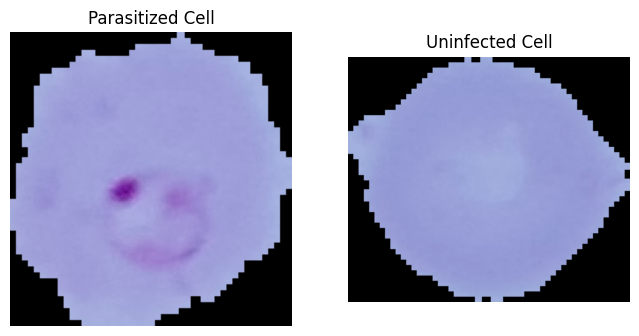

In [4]:
infected = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
uninfected = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png')
fig,ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(infected)
ax[0].set_title("Parasitized Cell")
ax[0].axis("off")
ax[1].imshow(uninfected)
ax[1].set_title("Uninfected Cell")
ax[1].axis("off")
plt.show()

In [5]:
id2int = {'Parasitized' : 0,'Uninfected':1}

In [6]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ColorJitter(
        brightness = (0.95,1.05),
        contrast = (0.95,1.05),
        saturation = (0.95,1.05),
        hue = (0.05)
    ),
    transforms.RandomAffine(5,translate = (0.01,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5,0.5,0.5],
        std = [0.5,0.5,0.5]
    )
])

In [7]:
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5,0.5,0.5],
        std = [0.5,0.5,0.5]
    )
])

In [8]:
class MalaraiaImages(Dataset):
  def __init__(self,files,transform = None):
    self.files = files
    self.transform = transform
    logger.info(len(self.files))

  def __len__(self):
    return len(self.files)

  def __getitem__(self,ix):
    path = self.files[ix]
    path_arr = path.split('/')
    clss = path_arr[-2]
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img, clss


  def choose(self):
    return self[np.random.randint(len(self))]

  def collate_fn(self,batch):
    _imgs, classes = list(zip(*batch))
    if self.transform:
      imgs = [self.transform(img) for img in _imgs]

    imgs = torch.stack(imgs).to(device)
    classes = torch.tensor([id2int[c] for c in classes]).to(device)
    return imgs,classes, _imgs


In [9]:
all_files = glob('/kaggle/input/cell-images-for-detecting-malaria/cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

In [10]:
train_files,val_files = train_test_split(all_files,test_size=0.2,random_state=1)
len(train_files),len(val_files)

(22046, 5512)

In [11]:
val_files, test_files = train_test_split(val_files,test_size=0.5,random_state=1)
len(val_files),len(test_files)

(2756, 2756)

In [12]:
train_dataset = MalaraiaImages(train_files,transform = train_transform)
val_dataset = MalaraiaImages(val_files,transform = val_transform)
test_dataset = MalaraiaImages(test_files,transform = val_transform)

[09/21/25 10:30:13] INFO     22046                                                                                                                   ]8;id=502525;file:///tmp/ipykernel_36/682835298.py:5\682835298.py]8;;\:]8;id=382123;file:///tmp/ipykernel_36/682835298.py:5#__init__:5\__init__:5]8;;\

                    INFO     2756                                                                                                                    ]8;id=889780;file:///tmp/ipykernel_36/682835298.py:5\682835298.py]8;;\:]8;id=592743;file:///tmp/ipykernel_36/682835298.py:5#__init__:5\__init__:5]8;;\

                    INFO     2756                                                                                                                    ]8;id=871142;file:///tmp/ipykernel_36/682835298.py:5\682835298.py]8;;\:]8;id=949081;file:///tmp/ipykernel_36/682835298.py:5#__init__:5\__init__:5]8;;\

In [13]:
train_loader = DataLoader(train_dataset,batch_size = 64,shuffle=True,collate_fn = train_dataset.collate_fn)
val_loader = DataLoader(val_dataset,batch_size = 64,shuffle=False,collate_fn = val_dataset.collate_fn)
test_loader = DataLoader(test_dataset,batch_size = 64,shuffle=False,collate_fn = test_dataset.collate_fn)

In [141]:
def conv_block(in_ch,out_ch):
  return nn.Sequential(
      nn.Dropout(0.2),
      nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1),
      nn.ReLU(inplace=False),
      nn.BatchNorm2d(out_ch),
      nn.MaxPool2d(2),
  )

In [142]:
class MalariaClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        conv_block(3,64),
        conv_block(64,64),
        conv_block(64,128),
        conv_block(128,256),
        conv_block(256,512),
        conv_block(512,64),
        nn.Flatten(),
        nn.Linear(256,256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=False),
        nn.Linear(256,len(id2int)),
    )
    self.loss_fn = nn.CrossEntropyLoss()
  def forward(self,x):
    return self.model(x)
  

  def compute_metrics(self,preds,targets):
    loss = self.loss_fn(preds,targets)
    acc = (torch.max(preds,1)[1] == targets).float().mean()
    return loss,acc


In [143]:
def train_batch(model,data,optimizer,criterion):
  model.train()
  imgs,labels, _ = data
  imgs,labels = imgs.to(device),labels.to(device)
  _preds = model(imgs)
  optimizer.zero_grad()
  loss,acc = criterion(_preds,labels)
  loss.backward()
  optimizer.step()

  return loss.item(), acc.item()

In [144]:
@torch.no_grad()
def validate_batch(model,data,criterion):
  model.eval()
  imgs,labels,_ = data
  imgs,labels = imgs.to(device),labels.to(device)
  _preds = model(imgs)
  loss,acc = criterion(_preds,labels)
  return loss.item(), acc.item()


In [145]:
model = MalariaClassifier()
model = model.to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 2
log = Report(n_epochs)

In [146]:
for i in range(n_epochs):
  N = len(train_loader)
  for j, data in enumerate(train_loader):
    train_loss, train_accuracy = train_batch(model,data,optimizer,criterion)
    log.record(i+(j+1) / N,trn_loss=train_loss,trn_acc=train_accuracy,end='\r')
  N = len(val_loader)
  for j,data in enumerate(val_loader):
    val_loss,val_accuracy = validate_batch(model,data,criterion)
    log.record(i+(j+1)/N,val_loss=val_loss,val_acc=val_accuracy,end='\r')
  
  log.report_avgs(i+1)

EPOCH: 1.000  val_acc: 0.932  trn_loss: 0.247  trn_acc: 0.903  val_loss: 0.229  (141.39s - 141.39s remaining)
EPOCH: 2.000  val_acc: 0.944  trn_loss: 0.165  trn_acc: 0.947  val_loss: 0.167  (276.69s - 0.00s remaining)


In [147]:
im2fmap = map = nn.Sequential(*(list(model.model[:5].children())+ list(model.model[5][:2].children())))

In [160]:
features = []
gradients = []

def forward_hook(module,input,output):
    features.append(output)
def backward_hook(module,grad_in,grad_out):
    gradients.append(grad_out[0])

In [165]:
target_layer = model.model[4]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [167]:
def im2GradCAM(x):
    features.clear()
    gradients.clear()
    
    logits = model(x)
    pred_idx = int(logits[0].argmax().item())
    scalar_logit = logits[0,pred_idx]
    model.zero_grad()
    scalar_logit.backward(retain_graph=True)

    activations = features[0].detach()
    grads = gradients[0].detach()

    pooled_grads = grads.mean(dim=(0,2,3))
    weights = pooled_grads.view(1,-1,1,1)

    weighted_activation = activations * weights

    heatmap = weighted_activation.mean(dim=1)[0].cpu()
    label = "Uninfected" if pred_idx == 1 else "Parasitized"
    return heatmap, label

In [168]:
SZ = 128
def UpsampleHeatMap(hmap,img):
    m,M = hmap.min(), hmap.max()
    hmap = 255 * ((hmap-m) / (M-m))
    hmap = np.uint8(hmap)
    hmap = cv2.resize(hmap,(SZ,SZ))
    hmap = cv2.applyColorMap(255-hmap, cv2.COLORMAP_JET)
    hmap = np.uint8(hmap)
    hmap = np.uint8(hmap*0.7 + img*0.3)
    return hmap
    
    

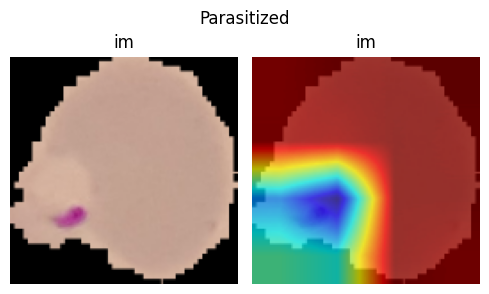

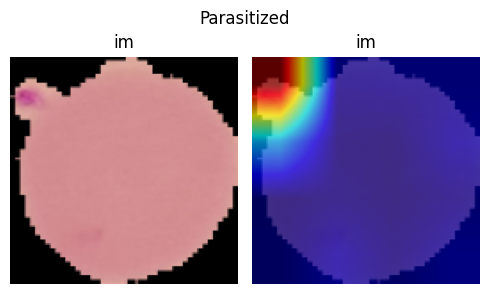

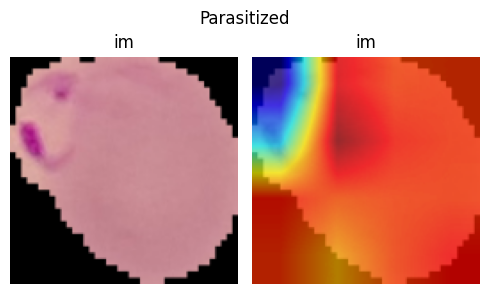

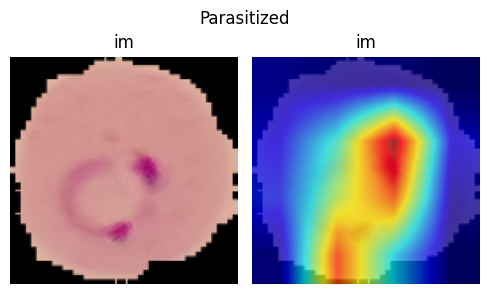

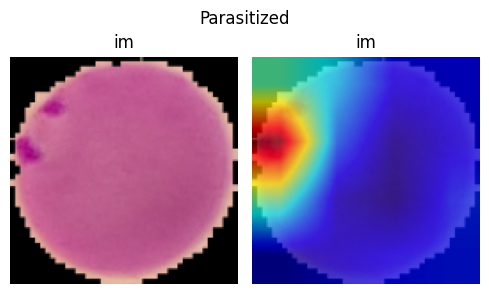

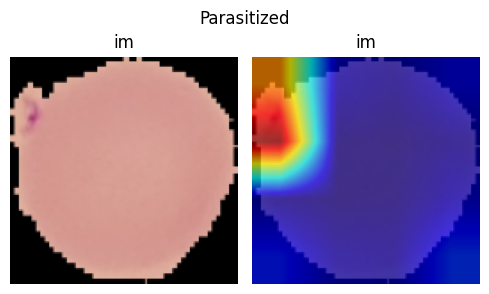

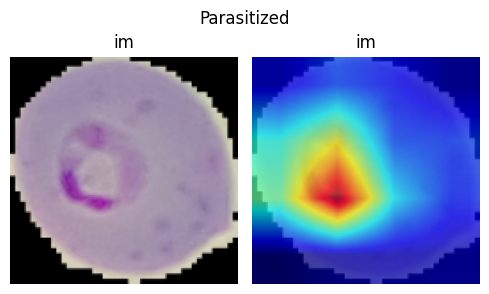

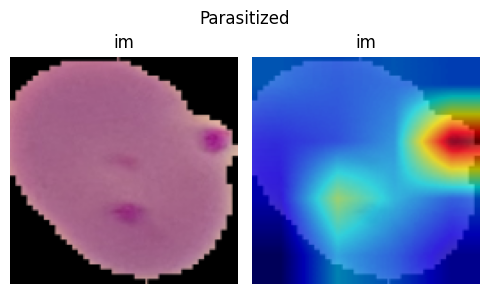

In [169]:
N = 20
_val_dl = DataLoader(val_dataset, batch_size=N, shuffle=True, collate_fn=val_dataset.collate_fn)
x,y,z = next(iter(_val_dl))
for i in range(N):
    image = resize(z[i],SZ)
    heatmap,pred = im2GradCAM(x[i:i+1])
    if (pred == "Uninfected"):
        continue
    heatmap = UpsampleHeatMap(heatmap,image)
    subplots([image,heatmap],nc=2,figsize=(5,3),suptitle=pred)

    

In [171]:
torch.save(model.state_dict(),'malaria_model.pth')

In [173]:
from huggingface_hub import login, HfApi, upload_file

In [174]:
login()

In [176]:
api = HfApi()

In [178]:
repo_url = api.create_repo(repo_id='Malaria-CAM',repo_type='space',space_sdk='gradio')
print(repo_url)

https://huggingface.co/spaces/faranbutt789/Malaria-CAM


In [181]:
repo_id = "faranbutt789/Malaria-CAM"
upload_file(
    path_or_fileobj = '/kaggle/working/malaria_model.pth',
    path_in_repo = 'malaria_model.pth',
    repo_id=repo_id,
    repo_type="space"
)

Uploading...:   0%|          | 0.00/7.83M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/faranbutt789/Malaria-CAM/commit/b37a4f7b05d7aa4d1723bc6b3e329174b2b6e11a', commit_message='Upload malaria_model.pth with huggingface_hub', commit_description='', oid='b37a4f7b05d7aa4d1723bc6b3e329174b2b6e11a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/faranbutt789/Malaria-CAM', endpoint='https://huggingface.co', repo_type='space', repo_id='faranbutt789/Malaria-CAM'), pr_revision=None, pr_num=None)

In [180]:
!pwd

/kaggle/working
